In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.core.display as di;
pd.options.display.max_columns = 100
%config InlineBackend.figure_format = 'svg'
di.display_markdown(raw=True)
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

## 交易数据集挖掘 解题报告



### 数据集说明
1. 下面几个题目中，
    * 训练集：2、3、4月数据做feature、5月数据作为label
    * 测试集：4、5、6月数据做feature、7月数据作为label
    * 输出：5、6、7月数据做feature，输出8月的预测结果
    * 考察在测试集上的预测结果。


### Evaluation
预测用户在第k+1个月会购买哪些商品、品牌、品类及是否会购买，这些二元分类问题的类间数据均不平衡，所以，这几个问题里不用Accuracy作为metric，用roc_auc。
当测试集中的正负样本的分布变化的时候，ROC曲线能够保持不变。

### a.构建交易特征
利用训练数据中每个用户前K-1个月的交易记录构建交易特征，第k个月用户购买行为构建该月用户购买行为类别。通过机器学习算法训练用户前K-1个月的交易特征和第k个月的购买行为标签购买相应的机器学习模型，测试用户在第k+1个月的购买行为。

构建特征的代码在 build_feature.py， 共构建了以下特征：
1. monthly count
2. monthly / whole period product diversity
3. monthly / whole period penetration
4. month AGG
5. user AGG
6. brand/category/item AGG
7. last week / last month feature
8. trend
9. repeat feature


* 实际操作中，构建特征比较费时，所以保存每一类特征的数据。针对这几个题目，读取特征数据，再组合相关特征，生成相应数据并保存。
* 组合相关特征后，每个题目用到的的数据集中特征数都是100+，训练前，通过ExtraTreesClassifier进行特征选择。
* 由于数据集不均衡，每个题目中都采用欠采样后的数据。



### b.预测用户在第k+1个月会购买哪些商品
对于测试集中每一对<用户, 商品>对，输出其在下个月是否购买，Yes表示购买，No表示不购买，每一行对应一对<用户, 商品>对及其标签，三个字段以逗号分隔: [用户], [商品], [标签]

以下是每个分类器的预测结果：
* Test_auc表示分类器在测试集上的AUC
* Test_precision表示分类器在测试集上的准确率
* Correct表示预测正确的数量
* Error表示预测错误的数量
* Correct value counts表示预测正确的结果的类别分布
* Error value counts表示预测错误的结果的类别分布

In [3]:
b = pd.read_csv('../data/output/1452983_2b_statics.txt')
b

,Model,Test_auc,Test_precision,Time,Correct,Error,Correct value counts,Error value counts,Estimator
0,GradientBoostingClassifier,0.650044,0.804361,7.988667,6677,1624,"{0.0: 6461, 1.0: 216}","{1.0: 1387, 0.0: 237}",GradientBoostingClassifier(criterion='friedman...
1,GaussianNB,0.644026,0.838212,0.080202,6958,1343,"{0.0: 6765, 1.0: 193}","{1.0: 1083, 0.0: 260}",GaussianNB(priors=None)
2,AdaBoostClassifier,0.643093,0.767618,3.523339,6372,1929,"{0.0: 6144, 1.0: 228}","{1.0: 1704, 0.0: 225}","AdaBoostClassifier(algorithm='SAMME.R', base_e..."
3,KNeighborsClassifier,0.562319,0.874473,2.196838,7259,1042,"{0.0: 7163, 1.0: 96}","{1.0: 685, 0.0: 357}","KNeighborsClassifier(algorithm='auto', leaf_si..."
4,DecisionTreeClassifier,0.539913,0.902903,0.098317,7495,806,"{0.0: 7435, 1.0: 60}","{1.0: 413, 0.0: 393}",DecisionTreeClassifier(class_weight='balanced'...
5,BaggingClassifier,0.524427,0.934586,5.908806,7758,543,"{0.0: 7729, 1.0: 29}","{0.0: 424, 1.0: 119}","BaggingClassifier(base_estimator=None, bootstr..."
6,RandomForestClassifier,0.519718,0.943380,1.145671,7831,470,"{0.0: 7811, 1.0: 20}","{0.0: 433, 1.0: 37}","RandomForestClassifier(bootstrap=True, class_w..."


* 分类器-准确率

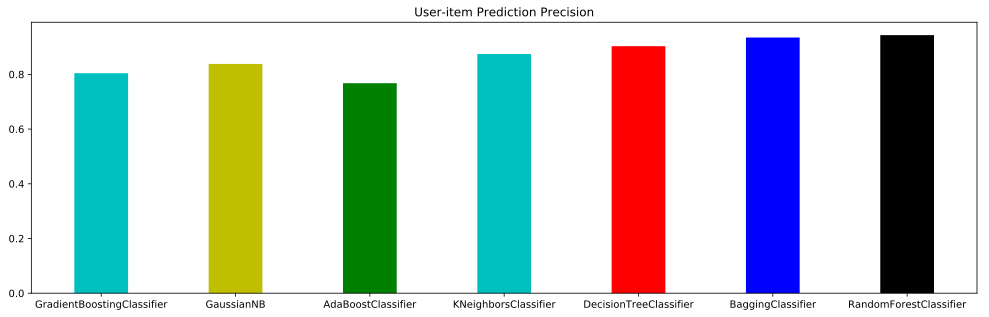

In [4]:
plt.figure(figsize=(17,5))
plt.bar(range(b.shape[0]), b['Test_precision'], tick_label=b['Model'], color="cygcrbk", width=0.4)
plt.title('User-item Prediction Precision')
plt.show()

分类器-AUC

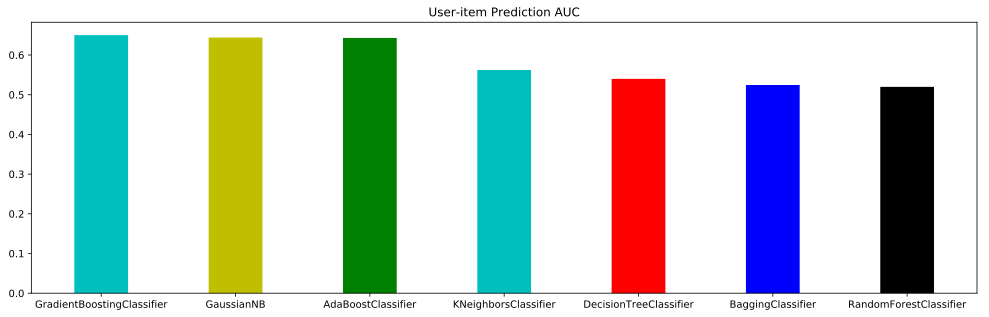

In [5]:
plt.figure(figsize=(17,5))
plt.bar(range(b.shape[0]), b['Test_auc'], tick_label=b['Model'], color="cygcrbk", width=0.4)
plt.title('User-item Prediction AUC')
plt.show()

* 分类器-训练时间

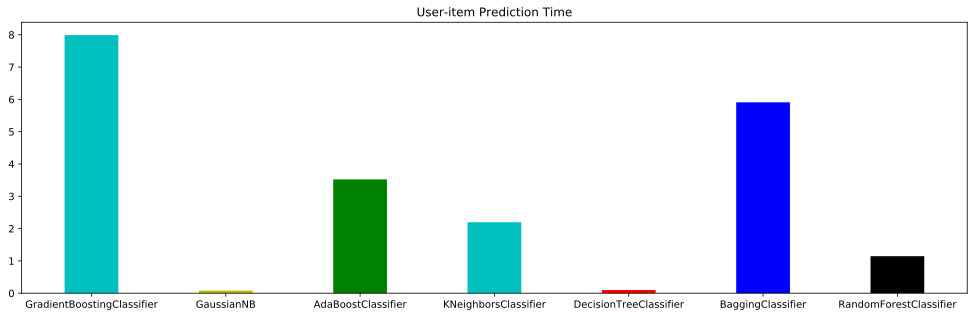

In [6]:
plt.figure(figsize=(17,5))
plt.bar(range(b.shape[0]), b['Time'], tick_label=b['Model'], color="cygcrbk", width=0.4)
plt.title('User-item Prediction Time')
plt.show()

由上图可知， 
* AdaBoostClassifier、GradientBoostingClassifier用时相对较长，但预测效果最好，AUC在65%上下波动。

### ci.预测用户是否会在第k+1个月购买
对于测试集里面的每一个用户，输出Yes或者No，输出格式为每行对应一个用户和其标签，用逗号分隔：[用户], [标签]
以下是每个分类器的预测结果：

In [7]:
ci = pd.read_csv('../data/output/1452983_2ci_statics.txt')
ci

,Model,Test_auc,Test_precision,Time,Correct,Error,Correct value counts,Error value counts,Estimator
0,GaussianNB,0.639784,0.637232,0.004408,267,152,"{1.0: 179, 0.0: 88}","{0.0: 104, 1.0: 48}",GaussianNB(priors=None)
1,RandomForestClassifier,0.606994,0.706444,0.129255,296,123,"{1.0: 252, 0.0: 44}","{1.0: 92, 0.0: 31}","RandomForestClassifier(bootstrap=True, class_w..."
2,GradientBoostingClassifier,0.589469,0.680191,0.151470,285,134,"{1.0: 240, 0.0: 45}","{1.0: 91, 0.0: 43}",GradientBoostingClassifier(criterion='friedman...
3,AdaBoostClassifier,0.586079,0.673031,0.186952,282,137,"{1.0: 236, 0.0: 46}","{1.0: 90, 0.0: 47}","AdaBoostClassifier(algorithm='SAMME.R', base_e..."
4,KNeighborsClassifier,0.574140,0.649165,0.006504,272,147,"{1.0: 223, 0.0: 49}","{1.0: 87, 0.0: 60}","KNeighborsClassifier(algorithm='auto', leaf_si..."
5,BaggingClassifier,0.573854,0.653938,0.064810,274,145,"{1.0: 227, 0.0: 47}","{1.0: 89, 0.0: 56}","BaggingClassifier(base_estimator=None, bootstr..."
6,DecisionTreeClassifier,0.541195,0.625298,0.031063,262,157,"{1.0: 221, 0.0: 41}","{1.0: 95, 0.0: 62}",DecisionTreeClassifier(class_weight='balanced'...


* 分类器-准确率

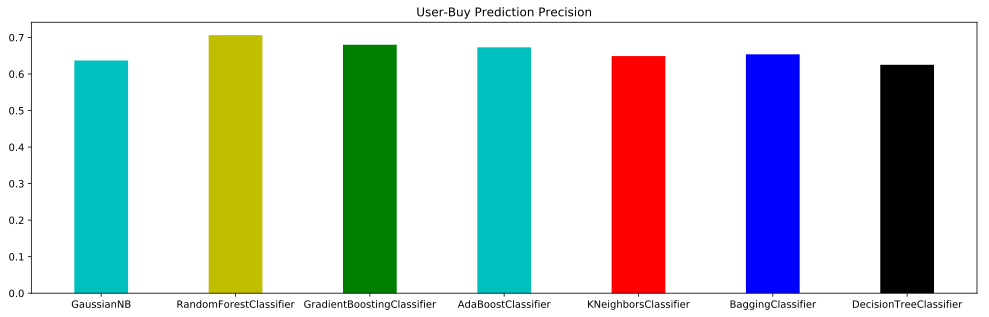

In [8]:
plt.figure(figsize=(17,5))
plt.bar(range(ci.shape[0]), ci['Test_precision'], tick_label=ci['Model'], color="cygcrbk", width=0.4)
plt.title('User-Buy Prediction Precision')
plt.show()

* 分类器-AUC

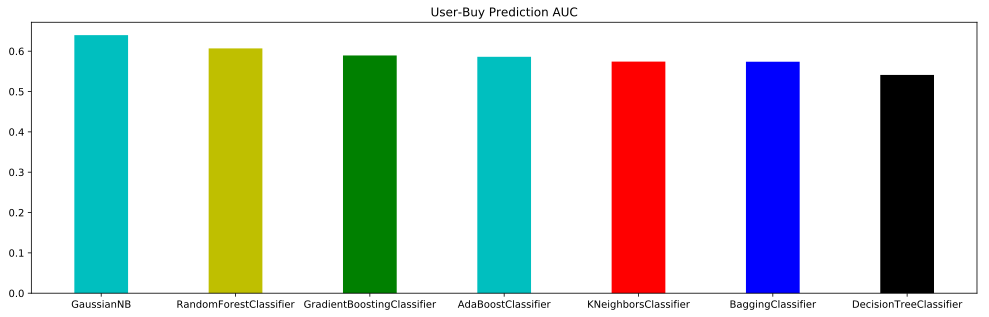

In [9]:
plt.figure(figsize=(17,5))
plt.bar(range(ci.shape[0]), ci['Test_auc'], tick_label=ci['Model'], color="cygcrbk", width=0.4)
plt.title('User-Buy Prediction AUC')
plt.show()

* 分类器-时间

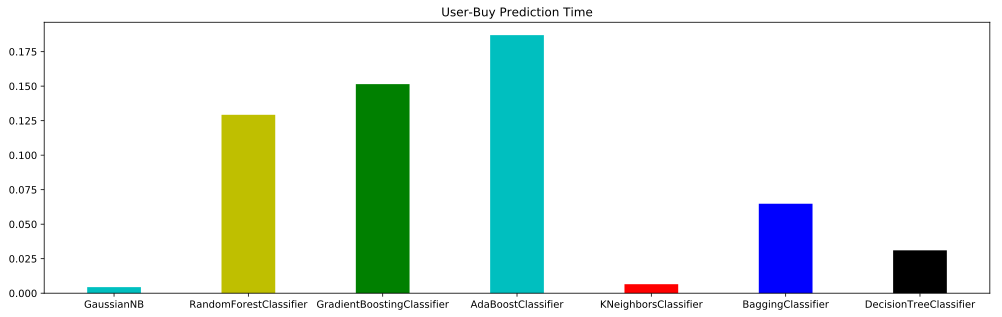

In [10]:
plt.figure(figsize=(17,5))
plt.bar(range(ci.shape[0]), ci['Time'], tick_label=ci['Model'], color="cygcrbk", width=0.4)
plt.title('User-Buy Prediction Time')
plt.show()

由上图可知，

* 所有分类器的AUC均在60%左右波动，性能并不是很好。
* 训练时间均在可接受的范围内

### cii.预测用户是否会在下个月购买该品牌
对于测试集里面每一个<用户, 品牌>对，输出其在下个月是否购买该品牌，Yes表示购买，No表示不购买，输出每一行对应一对<用户, 品牌>对及其标签，三个字段以逗号分隔: [用户], [品牌], [标签]

以下是每个分类器的预测结果：

In [11]:
cii = pd.read_csv('../data/output/1452983_2cii_statics.txt')
cii
#undersample

,Model,Test_auc,Test_precision,Time,Correct,Error,Correct value counts,Error value counts,Estimator
0,RandomForestClassifier,0.750569,0.782767,0.397686,3225,895,"{0.0: 2793, 1.0: 432}","{1.0: 714, 0.0: 181}","RandomForestClassifier(bootstrap=True, class_w..."
1,GradientBoostingClassifier,0.748245,0.757039,0.907044,3119,1001,"{0.0: 2668, 1.0: 451}","{1.0: 839, 0.0: 162}",GradientBoostingClassifier(criterion='friedman...
2,BaggingClassifier,0.717194,0.741990,0.842027,3057,1063,"{0.0: 2639, 1.0: 418}","{1.0: 868, 0.0: 195}","BaggingClassifier(base_estimator=None, bootstr..."
3,AdaBoostClassifier,0.716451,0.752184,0.919039,3099,1021,"{0.0: 2691, 1.0: 408}","{1.0: 816, 0.0: 205}","AdaBoostClassifier(algorithm='SAMME.R', base_e..."
4,KNeighborsClassifier,0.703570,0.716505,0.731840,2952,1168,"{0.0: 2532, 1.0: 420}","{1.0: 975, 0.0: 193}","KNeighborsClassifier(algorithm='auto', leaf_si..."
5,GaussianNB,0.678149,0.869175,0.057281,3581,539,"{0.0: 3332, 1.0: 249}","{0.0: 364, 1.0: 175}",GaussianNB(priors=None)
6,DecisionTreeClassifier,0.677844,0.675000,0.025985,2781,1339,"{0.0: 2363, 1.0: 418}","{1.0: 1144, 0.0: 195}",DecisionTreeClassifier(class_weight='balanced'...


* 分类器-准确率

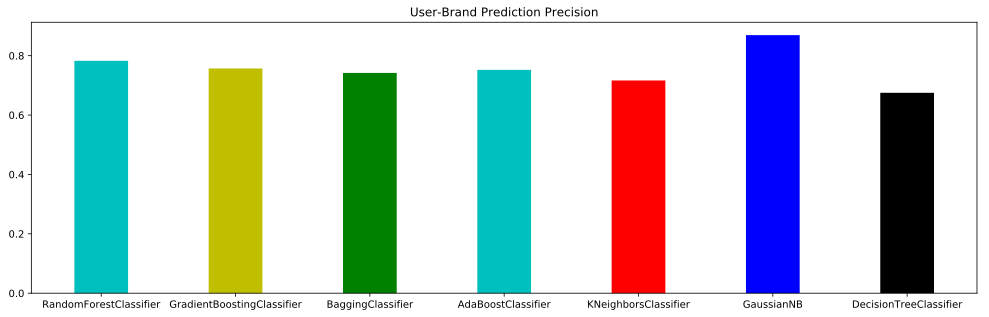

In [12]:
plt.figure(figsize=(17,5))
plt.bar(range(cii.shape[0]), cii['Test_precision'], tick_label=cii['Model'], color="cygcrbk", width=0.4)
plt.title('User-Brand Prediction Precision')
plt.show()

* 分类器-AUC

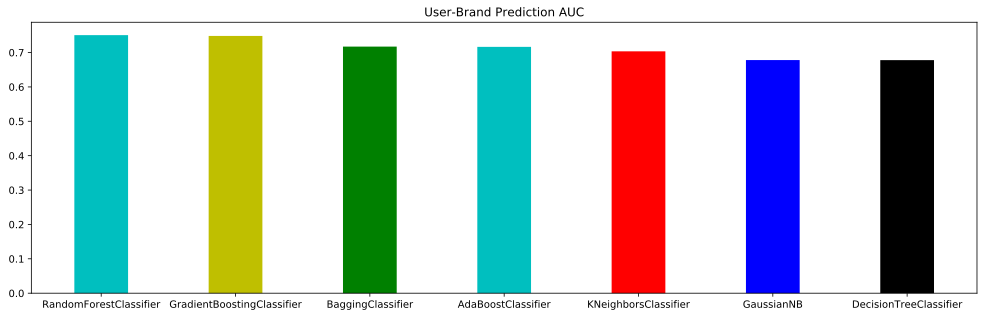

In [13]:
plt.figure(figsize=(17,5))
plt.bar(range(cii.shape[0]), cii['Test_auc'], tick_label=cii['Model'], color="cygcrbk", width=0.4)
plt.title('User-Brand Prediction AUC')
plt.show()

* 分类器-时间

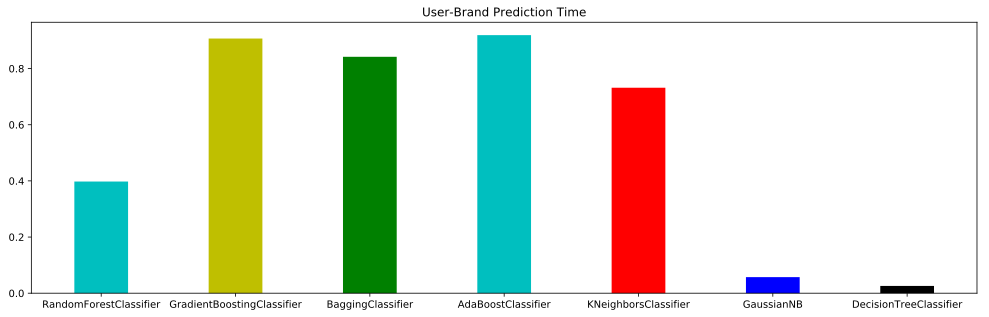

In [14]:
plt.figure(figsize=(17,5))
plt.bar(range(cii.shape[0]), cii['Time'], tick_label=cii['Model'], color="cygcrbk", width=0.4)
plt.title('User-Brand Prediction Time')
plt.show()

由上图可知， 
* RandomForestClassifier预测效果最好，四个集成学习器的AUC均为70%+。
* 训练时间均在可接受的范围内


### ciii.预测用户是否会在下个月购买该品类

In [15]:
ciii = pd.read_csv('../data/output/1452983_2ciii_statics.txt')
ciii

,Model,Test_auc,Test_precision,Time,Correct,Error,Correct value counts,Error value counts,Estimator
0,RandomForestClassifier,0.678291,0.693195,0.333504,4686,2074,"{0.0: 4244, 1.0: 442}","{1.0: 1846, 0.0: 228}","RandomForestClassifier(bootstrap=True, class_w..."
1,GradientBoostingClassifier,0.672262,0.701479,0.573656,4742,2018,"{0.0: 4316, 1.0: 426}","{1.0: 1774, 0.0: 244}",GradientBoostingClassifier(criterion='friedman...
2,GaussianNB,0.664069,0.790828,0.021578,5346,1414,"{0.0: 5007, 1.0: 339}","{1.0: 1083, 0.0: 331}",GaussianNB(priors=None)
3,AdaBoostClassifier,0.651964,0.707988,0.487434,4786,1974,"{0.0: 4396, 1.0: 390}","{1.0: 1694, 0.0: 280}","AdaBoostClassifier(algorithm='SAMME.R', base_e..."
4,BaggingClassifier,0.639600,0.720414,0.620314,4870,1890,"{0.0: 4509, 1.0: 361}","{1.0: 1581, 0.0: 309}","BaggingClassifier(base_estimator=None, bootstr..."
5,KNeighborsClassifier,0.614577,0.632249,0.393073,4274,2486,"{0.0: 3877, 1.0: 397}","{1.0: 2213, 0.0: 273}","KNeighborsClassifier(algorithm='auto', leaf_si..."
6,DecisionTreeClassifier,0.606448,0.604438,0.015969,4086,2674,"{0.0: 3678, 1.0: 408}","{1.0: 2412, 0.0: 262}",DecisionTreeClassifier(class_weight='balanced'...


* 分类器-准确率

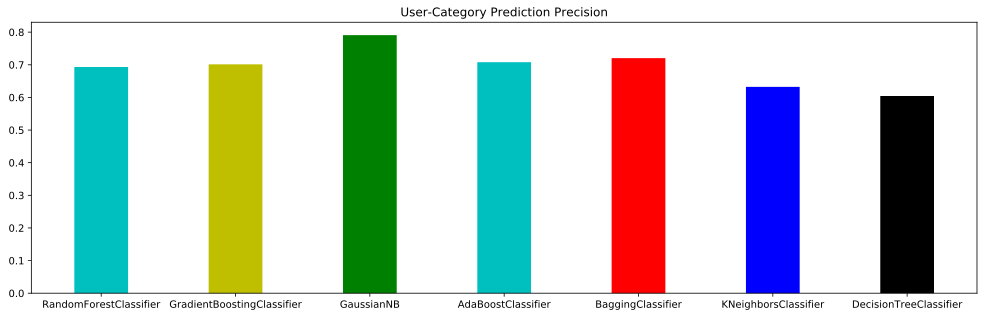

In [16]:
plt.figure(figsize=(17,5))
plt.bar(range(ciii.shape[0]), ciii['Test_precision'], tick_label=ciii['Model'], color="cygcrbk", width=0.4)
plt.title('User-Category Prediction Precision')
plt.show()

* 分类器-AUC

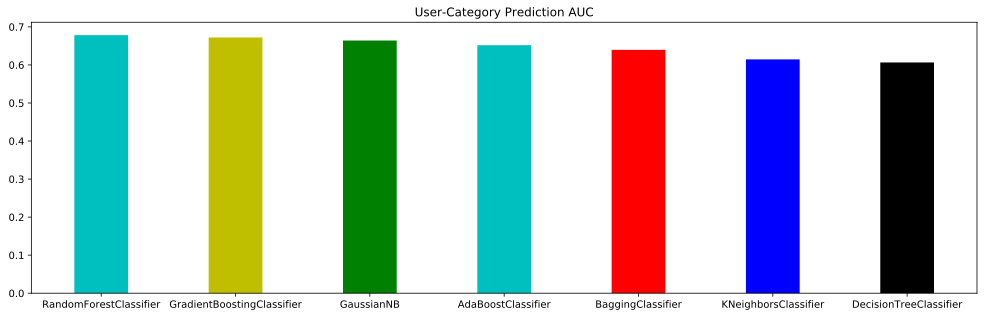

In [17]:
plt.figure(figsize=(17,5))
plt.bar(range(ciii.shape[0]), ciii['Test_auc'], tick_label=ciii['Model'], color="cygcrbk", width=0.4)
plt.title('User-Category Prediction AUC')
plt.show()

* 分类器-时间

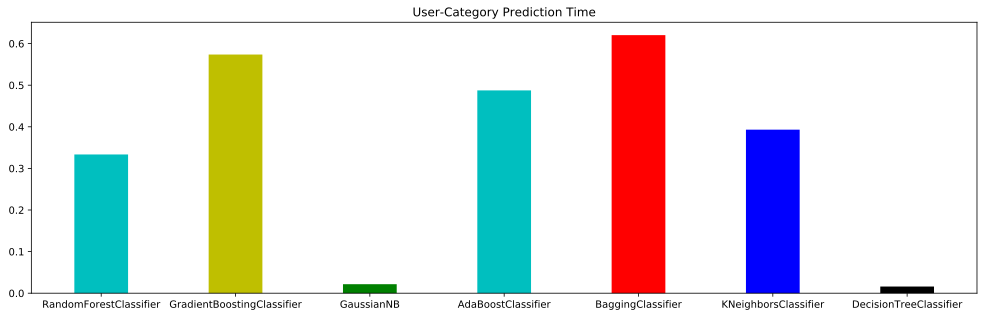

In [18]:
plt.figure(figsize=(17,5))
plt.bar(range(ciii.shape[0]), ciii['Time'], tick_label=ciii['Model'], color="cygcrbk", width=0.4)
plt.title('User-Category Prediction Time')
plt.show()

由上图可知，
* 这几个集成学习分类器性能与GaussianNB相差无几，AUC均为66%+。
* 训练时间均在可接受的范围内

### civ.预测用户下个月的消费金额

* 用均方根误差MSE和平均绝对误差MAE反映预测的误差情况.
* 这里依赖ci的预测结果（预测用户下个月是否购买，购买的话label为1，不购买的话label为0），将预测出的下月消费金额与ci预测结果相乘，使得被预测下月不购买的用户的预测金额为0.

In [19]:
civ = pd.read_csv('../data/output/1452983_2civ_statics.txt')
civ

,Model,Test_EVS,Test_MAE,Test_MSE,Time,Estimator
0,BaggingRegressor,-0.071726,90.637573,23281.653431,0.153159,BaggingRegressor(base_estimator=DecisionTreeRe...
1,KNeighborsRegressor,-0.082917,89.894253,23853.342632,0.016172,"KNeighborsRegressor(algorithm='auto', leaf_siz..."
2,RandomForestRegressor,-0.188399,94.762771,24962.238180,0.325743,"RandomForestRegressor(bootstrap=True, criterio..."
3,GradientBoostingRegressor,-0.196182,93.314522,25545.673920,0.164954,"GradientBoostingRegressor(alpha=0.9, criterion..."
4,AdaBoostRegressor,-0.367184,109.912111,27385.106731,0.170519,AdaBoostRegressor(base_estimator=DecisionTreeR...
5,GaussianProcessRegressor,0.000000,99.177041,29823.342259,0.154103,"GaussianProcessRegressor(alpha=1e-10, copy_X_t..."
6,DecisionTreeRegressor,-0.650699,98.078169,34697.141926,0.004354,"DecisionTreeRegressor(criterion='mse', max_dep..."


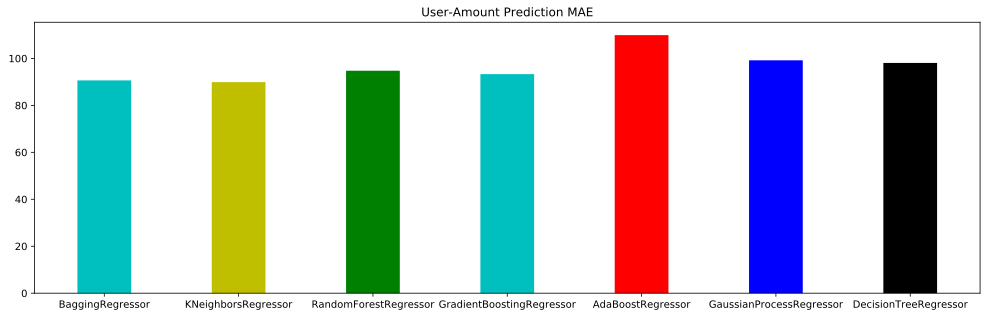

In [20]:
plt.figure(figsize=(17,5))
plt.bar(range(civ.shape[0]), civ['Test_MAE'], tick_label=civ['Model'], color="cygcrbk", width=0.4)
plt.title('User-Amount Prediction MAE')
plt.show()

由上图可知，
* 除AdaBoostRegressor外，其他回归方法的预测误差相差无几，在90上下波动，其中KNeighborsRegressor预测效果最好。
* 这里ci的预测结果直接影响预测误差大小。
* 上述所有回归方法的预测值均为正，可以不考虑ci的预测结果，直接输出预测金额。

